In [ ]:
import math
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint

# for colab use
missing_libraries = []
try:
    from einops import rearrange
except ImportError:
    missing_libraries.append("einops")
try:
    import triton
    import triton.language as tl
except ImportError:
    missing_libraries.append("triton")
try:
    from basicsr.utils.registry import ARCH_REGISTRY
    from basicsr.archs.arch_util import to_2tuple, trunc_normal_
except ImportError:
    missing_libraries.append("basicsr")
# try:
#    import torchmetrics
# except ImportError:
#    missing_libraries.append("torchmetrics")
try:
    from torchgeometry.image import get_gaussian_kernel2d
except ImportError:
    missing_libraries.append("torchgeometry")

if missing_libraries:
    print("The following libraries are missing: " + ", ".join(missing_libraries))
    print("Installing missing libraries...")
    if "einops" in missing_libraries:
        !pip install einops
        from einops import rearrange
    if "triton" in missing_libraries:
        !pip install triton
        import triton
        import triton.language as tl
    if "basicsr" in missing_libraries:
        !pip install basicsr
        from basicsr.utils.registry import ARCH_REGISTRY
        from basicsr.archs.arch_util import to_2tuple, trunc_normal_
    if "torchgeometry" in missing_libraries:
        !pip install torchgeometry
        from torchgeometry.image import get_gaussian_kernel2d
    #    if "torchmetrics" in missing_libraries:
    #        !pip install torchmetrics
    #        from torchgeometry.image import get_gaussian_kernel2d
    print("Libraries installed successfully.")
else:
    print("All required libraries are already installed.")


def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (
        x.ndim - 1
    )  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).

    From: https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/layers/drop.py
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)


class ChannelAttention(nn.Module):
    """Channel attention used in RCAN.
    Args:
        num_feat (int): Channel number of intermediate features.
        squeeze_factor (int): Channel squeeze factor. Default: 16.
    """

    def __init__(self, num_feat, squeeze_factor=16):
        super(ChannelAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(num_feat, num_feat // squeeze_factor, 1, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_feat // squeeze_factor, num_feat, 1, padding=0),
            nn.Sigmoid(),
        )

    def forward(self, x):
        y = self.attention(x)
        return x * y


class CAB(nn.Module):
    def __init__(self, num_feat, compress_ratio=3, squeeze_factor=30):
        super(CAB, self).__init__()

        self.cab = nn.Sequential(
            nn.Conv2d(num_feat, num_feat // compress_ratio, 3, 1, 1),
            nn.GELU(),
            nn.Conv2d(num_feat // compress_ratio, num_feat, 3, 1, 1),
            ChannelAttention(num_feat, squeeze_factor),
        )

    def forward(self, x):
        return self.cab(x)


class Mlp(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_features=None,
        out_features=None,
        act_layer=nn.GELU,
        drop=0.0,
    ):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (b, h, w, c)
        window_size (int): window size

    Returns:
        windows: (num_windows*b, window_size, window_size, c)
    """
    b, h, w, c = x.shape
    x = x.view(b, h // window_size, window_size, w // window_size, window_size, c)
    windows = (
        x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, c)
    )
    return windows


def window_reverse(windows, window_size, h, w):
    """
    Args:
        windows: (num_windows*b, window_size, window_size, c)
        window_size (int): Window size
        h (int): Height of image
        w (int): Width of image

    Returns:
        x: (b, h, w, c)
    """
    b = int(windows.shape[0] / (h * w / window_size / window_size))
    x = windows.view(
        b, h // window_size, w // window_size, window_size, window_size, -1
    )
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(b, h, w, -1)
    return x


class WindowAttention(nn.Module):
    r"""Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(
        self,
        dim,
        window_size,
        num_heads,
        qkv_bias=True,
        qk_scale=None,
        attn_drop=0.0,
        proj_drop=0.0,
    ):
        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads)
        )  # 2*Wh-1 * 2*Ww-1, nH

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, rpi, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*b, n, c)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        b_, n, c = x.shape
        qkv = (
            self.qkv(x)
            .reshape(b_, n, 3, self.num_heads, c // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size[0] * self.window_size[1],
            self.window_size[0] * self.window_size[1],
            -1,
        )  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1
        ).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nw = mask.shape[0]
            attn = attn.view(b_ // nw, nw, self.num_heads, n, n) + mask.unsqueeze(
                1
            ).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, n, n)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(b_, n, c)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class HAB(nn.Module):
    r"""Hybrid Attention Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(
        self,
        dim,
        input_resolution,
        num_heads,
        window_size=7,
        shift_size=0,
        compress_ratio=3,
        squeeze_factor=30,
        conv_scale=0.01,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        act_layer=nn.GELU,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert (
            0 <= self.shift_size < self.window_size
        ), "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim,
            window_size=to_2tuple(self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            attn_drop=attn_drop,
            proj_drop=drop,
        )

        self.conv_scale = conv_scale
        self.conv_block = CAB(
            num_feat=dim, compress_ratio=compress_ratio, squeeze_factor=squeeze_factor
        )

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim,
            hidden_features=mlp_hidden_dim,
            act_layer=act_layer,
            drop=drop,
        )

    def forward(self, x, x_size, rpi_sa, attn_mask):
        h, w = x_size
        b, _, c = x.shape
        # assert seq_len == h * w, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        # Conv_X
        conv_x = self.conv_block(x.permute(0, 3, 1, 2))
        conv_x = conv_x.permute(0, 2, 3, 1).contiguous().view(b, h * w, c)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(
                x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2)
            )
            attn_mask = attn_mask
        else:
            shifted_x = x
            attn_mask = None

        # partition windows
        x_windows = window_partition(
            shifted_x, self.window_size
        )  # nw*b, window_size, window_size, c
        x_windows = x_windows.view(
            -1, self.window_size * self.window_size, c
        )  # nw*b, window_size*window_size, c

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        attn_windows = self.attn(x_windows, rpi=rpi_sa, mask=attn_mask)

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, c)
        shifted_x = window_reverse(attn_windows, self.window_size, h, w)  # b h' w' c

        # reverse cyclic shift
        if self.shift_size > 0:
            attn_x = torch.roll(
                shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2)
            )
        else:
            attn_x = shifted_x
        attn_x = attn_x.view(b, h * w, c)

        # FFN
        x = shortcut + self.drop_path(attn_x) + conv_x * self.conv_scale
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x


class PatchMerging(nn.Module):
    r"""Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: b, h*w, c
        """
        h, w = self.input_resolution
        b, seq_len, c = x.shape
        assert seq_len == h * w, "input feature has wrong size"
        assert h % 2 == 0 and w % 2 == 0, f"x size ({h}*{w}) are not even."

        x = x.view(b, h, w, c)

        x0 = x[:, 0::2, 0::2, :]  # b h/2 w/2 c
        x1 = x[:, 1::2, 0::2, :]  # b h/2 w/2 c
        x2 = x[:, 0::2, 1::2, :]  # b h/2 w/2 c
        x3 = x[:, 1::2, 1::2, :]  # b h/2 w/2 c
        x = torch.cat([x0, x1, x2, x3], -1)  # b h/2 w/2 4*c
        x = x.view(b, -1, 4 * c)  # b h/2*w/2 4*c

        x = self.norm(x)
        x = self.reduction(x)

        return x


class OCAB(nn.Module):
    # overlapping cross-attention block

    def __init__(
        self,
        dim,
        input_resolution,
        window_size,
        overlap_ratio,
        num_heads,
        qkv_bias=True,
        qk_scale=None,
        mlp_ratio=2,
        norm_layer=nn.LayerNorm,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.window_size = window_size
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim**-0.5
        self.overlap_win_size = int(window_size * overlap_ratio) + window_size

        self.norm1 = norm_layer(dim)
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.unfold = nn.Unfold(
            kernel_size=(self.overlap_win_size, self.overlap_win_size),
            stride=window_size,
            padding=(self.overlap_win_size - window_size) // 2,
        )

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros(
                (window_size + self.overlap_win_size - 1)
                * (window_size + self.overlap_win_size - 1),
                num_heads,
            )
        )  # 2*Wh-1 * 2*Ww-1, nH

        trunc_normal_(self.relative_position_bias_table, std=0.02)
        self.softmax = nn.Softmax(dim=-1)

        self.proj = nn.Linear(dim, dim)

        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(
            in_features=dim, hidden_features=mlp_hidden_dim, act_layer=nn.GELU
        )

    def forward(self, x, x_size, rpi):
        h, w = x_size
        b, _, c = x.shape

        shortcut = x
        x = self.norm1(x)
        x = x.view(b, h, w, c)

        qkv = self.qkv(x).reshape(b, h, w, 3, c).permute(3, 0, 4, 1, 2)  # 3, b, c, h, w
        q = qkv[0].permute(0, 2, 3, 1)  # b, h, w, c
        kv = torch.cat((qkv[1], qkv[2]), dim=1)  # b, 2*c, h, w

        # partition windows
        q_windows = window_partition(
            q, self.window_size
        )  # nw*b, window_size, window_size, c
        q_windows = q_windows.view(
            -1, self.window_size * self.window_size, c
        )  # nw*b, window_size*window_size, c

        kv_windows = self.unfold(kv)  # b, c*w*w, nw
        kv_windows = rearrange(
            kv_windows,
            "b (nc ch owh oww) nw -> nc (b nw) (owh oww) ch",
            nc=2,
            ch=c,
            owh=self.overlap_win_size,
            oww=self.overlap_win_size,
        ).contiguous()  # 2, nw*b, ow*ow, c
        k_windows, v_windows = kv_windows[0], kv_windows[1]  # nw*b, ow*ow, c

        b_, nq, _ = q_windows.shape
        _, n, _ = k_windows.shape
        d = self.dim // self.num_heads
        q = q_windows.reshape(b_, nq, self.num_heads, d).permute(
            0, 2, 1, 3
        )  # nw*b, nH, nq, d
        k = k_windows.reshape(b_, n, self.num_heads, d).permute(
            0, 2, 1, 3
        )  # nw*b, nH, n, d
        v = v_windows.reshape(b_, n, self.num_heads, d).permute(
            0, 2, 1, 3
        )  # nw*b, nH, n, d

        q = q * self.scale
        attn = q @ k.transpose(-2, -1)

        relative_position_bias = self.relative_position_bias_table[rpi.view(-1)].view(
            self.window_size * self.window_size,
            self.overlap_win_size * self.overlap_win_size,
            -1,
        )  # ws*ws, wse*wse, nH
        relative_position_bias = relative_position_bias.permute(
            2, 0, 1
        ).contiguous()  # nH, ws*ws, wse*wse
        attn = attn + relative_position_bias.unsqueeze(0)

        attn = self.softmax(attn)
        attn_windows = (attn @ v).transpose(1, 2).reshape(b_, nq, self.dim)

        # merge windows
        attn_windows = attn_windows.view(
            -1, self.window_size, self.window_size, self.dim
        )
        x = window_reverse(attn_windows, self.window_size, h, w)  # b h w c
        x = x.view(b, h * w, self.dim)

        x = self.proj(x) + shortcut

        x = x + self.mlp(self.norm2(x))
        return x


class AttenBlocks(nn.Module):
    """A series of attention blocks for one RHAG.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(
        self,
        dim,
        input_resolution,
        depth,
        num_heads,
        window_size,
        compress_ratio,
        squeeze_factor,
        conv_scale,
        overlap_ratio,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
    ):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList(
            [
                HAB(
                    dim=dim,
                    input_resolution=input_resolution,
                    num_heads=num_heads,
                    window_size=window_size,
                    shift_size=0 if (i % 2 == 0) else window_size // 2,
                    compress_ratio=compress_ratio,
                    squeeze_factor=squeeze_factor,
                    conv_scale=conv_scale,
                    mlp_ratio=mlp_ratio,
                    qkv_bias=qkv_bias,
                    qk_scale=qk_scale,
                    drop=drop,
                    attn_drop=attn_drop,
                    drop_path=drop_path[i]
                    if isinstance(drop_path, list)
                    else drop_path,
                    norm_layer=norm_layer,
                )
                for i in range(depth)
            ]
        )

        # OCAB
        self.overlap_attn = OCAB(
            dim=dim,
            input_resolution=input_resolution,
            window_size=window_size,
            overlap_ratio=overlap_ratio,
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            mlp_ratio=mlp_ratio,
            norm_layer=norm_layer,
        )

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(
                input_resolution, dim=dim, norm_layer=norm_layer
            )
        else:
            self.downsample = None

    def forward(self, x, x_size, params):
        for blk in self.blocks:
            x = blk(x, x_size, params["rpi_sa"], params["attn_mask"])

        x = self.overlap_attn(x, x_size, params["rpi_oca"])

        if self.downsample is not None:
            x = self.downsample(x)
        return x


class RHAG(nn.Module):
    """Residual Hybrid Attention Group (RHAG).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(
        self,
        dim,
        input_resolution,
        depth,
        num_heads,
        window_size,
        compress_ratio,
        squeeze_factor,
        conv_scale,
        overlap_ratio,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop=0.0,
        attn_drop=0.0,
        drop_path=0.0,
        norm_layer=nn.LayerNorm,
        downsample=None,
        use_checkpoint=False,
        img_size=224,
        patch_size=4,
        resi_connection="1conv",
    ):
        super(RHAG, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = AttenBlocks(
            dim=dim,
            input_resolution=input_resolution,
            depth=depth,
            num_heads=num_heads,
            window_size=window_size,
            compress_ratio=compress_ratio,
            squeeze_factor=squeeze_factor,
            conv_scale=conv_scale,
            overlap_ratio=overlap_ratio,
            mlp_ratio=mlp_ratio,
            qkv_bias=qkv_bias,
            qk_scale=qk_scale,
            drop=drop,
            attn_drop=attn_drop,
            drop_path=drop_path,
            norm_layer=norm_layer,
            downsample=downsample,
            use_checkpoint=use_checkpoint,
        )

        if resi_connection == "1conv":
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == "identity":
            self.conv = nn.Identity()

        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=0,
            embed_dim=dim,
            norm_layer=None,
        )

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=0,
            embed_dim=dim,
            norm_layer=None,
        )

    def forward(self, x, x_size, params):
        return (
            self.patch_embed(
                self.conv(
                    self.patch_unembed(self.residual_group(x, x_size, params), x_size)
                )
            )
            + x
        )


class PatchEmbed(nn.Module):
    r"""Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(
        self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [
            img_size[0] // patch_size[0],
            img_size[1] // patch_size[1],
        ]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # b Ph*Pw c
        if self.norm is not None:
            x = self.norm(x)
        return x


class PatchUnEmbed(nn.Module):
    r"""Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(
        self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None
    ):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [
            img_size[0] // patch_size[0],
            img_size[1] // patch_size[1],
        ]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(x.shape[0], self.embed_dim, x_size[0], x_size[1])
        )  # b Ph*Pw c
        return x


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(
                f"scale {scale} is not supported. " "Supported scales: 2^n and 3."
            )
        super(Upsample, self).__init__(*m)


# @ARCH_REGISTRY.register()
class HAT(nn.Module):
    r"""Hybrid Attention Transformer
        A PyTorch implementation of : `Activating More Pixels in Image Super-Resolution Transformer`.
        Some codes are based on SwinIR.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(
        self,
        img_size=64,
        patch_size=1,
        in_chans=3,
        embed_dim=96,
        depths=(6, 6, 6, 6),
        num_heads=(6, 6, 6, 6),
        window_size=7,
        compress_ratio=3,
        squeeze_factor=30,
        conv_scale=0.01,
        overlap_ratio=0.5,
        mlp_ratio=4.0,
        qkv_bias=True,
        qk_scale=None,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_layer=nn.LayerNorm,
        ape=False,
        patch_norm=True,
        use_checkpoint=False,
        upscale=2,
        img_range=1.0,
        upsampler="",
        resi_connection="1conv",
        **kwargs,
    ):
        super(HAT, self).__init__()

        self.window_size = window_size
        self.shift_size = window_size // 2
        self.overlap_ratio = overlap_ratio

        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler

        # relative position index
        relative_position_index_SA = self.calculate_rpi_sa()
        relative_position_index_OCA = self.calculate_rpi_oca()
        self.register_buffer("relative_position_index_SA", relative_position_index_SA)
        self.register_buffer("relative_position_index_OCA", relative_position_index_OCA)

        # ------------------------- 1, shallow feature extraction ------------------------- #
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        # ------------------------- 2, deep feature extraction ------------------------- #
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,
        )
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=embed_dim,
            embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None,
        )

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(
                torch.zeros(1, num_patches, embed_dim)
            )
            trunc_normal_(self.absolute_pos_embed, std=0.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [
            x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))
        ]  # stochastic depth decay rule

        # build Residual Hybrid Attention Groups (RHAG)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RHAG(
                dim=embed_dim,
                input_resolution=(patches_resolution[0], patches_resolution[1]),
                depth=depths[i_layer],
                num_heads=num_heads[i_layer],
                window_size=window_size,
                compress_ratio=compress_ratio,
                squeeze_factor=squeeze_factor,
                conv_scale=conv_scale,
                overlap_ratio=overlap_ratio,
                mlp_ratio=self.mlp_ratio,
                qkv_bias=qkv_bias,
                qk_scale=qk_scale,
                drop=drop_rate,
                attn_drop=attn_drop_rate,
                drop_path=dpr[
                    sum(depths[:i_layer]) : sum(depths[: i_layer + 1])
                ],  # no impact on SR results
                norm_layer=norm_layer,
                downsample=None,
                use_checkpoint=use_checkpoint,
                img_size=img_size,
                patch_size=patch_size,
                resi_connection=resi_connection,
            )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == "1conv":
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == "identity":
            self.conv_after_body = nn.Identity()

        # ------------------------- 3, high quality image reconstruction ------------------------- #
        if self.upsampler == "pixelshuffle":
            # for classical SR
            self.conv_before_upsample = nn.Sequential(
                nn.Conv2d(embed_dim, num_feat, 3, 1, 1), nn.LeakyReLU(inplace=True)
            )
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=0.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def calculate_rpi_sa(self):
        # calculate relative position index for SA
        coords_h = torch.arange(self.window_size)
        coords_w = torch.arange(self.window_size)
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = (
            coords_flatten[:, :, None] - coords_flatten[:, None, :]
        )  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size - 1
        relative_coords[:, :, 0] *= 2 * self.window_size - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        return relative_position_index

    def calculate_rpi_oca(self):
        # calculate relative position index for OCA
        window_size_ori = self.window_size
        window_size_ext = self.window_size + int(self.overlap_ratio * self.window_size)

        coords_h = torch.arange(window_size_ori)
        coords_w = torch.arange(window_size_ori)
        coords_ori = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, ws, ws
        coords_ori_flatten = torch.flatten(coords_ori, 1)  # 2, ws*ws

        coords_h = torch.arange(window_size_ext)
        coords_w = torch.arange(window_size_ext)
        coords_ext = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, wse, wse
        coords_ext_flatten = torch.flatten(coords_ext, 1)  # 2, wse*wse

        relative_coords = (
            coords_ext_flatten[:, None, :] - coords_ori_flatten[:, :, None]
        )  # 2, ws*ws, wse*wse

        relative_coords = relative_coords.permute(
            1, 2, 0
        ).contiguous()  # ws*ws, wse*wse, 2
        relative_coords[:, :, 0] += (
            window_size_ori - window_size_ext + 1
        )  # shift to start from 0
        relative_coords[:, :, 1] += window_size_ori - window_size_ext + 1

        relative_coords[:, :, 0] *= window_size_ori + window_size_ext - 1
        relative_position_index = relative_coords.sum(-1)
        return relative_position_index

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        h, w = x_size
        img_mask = torch.zeros((1, h, w, 1))  # 1 h w 1
        h_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None),
        )
        w_slices = (
            slice(0, -self.window_size),
            slice(-self.window_size, -self.shift_size),
            slice(-self.shift_size, None),
        )
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(
            img_mask, self.window_size
        )  # nw, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(
            attn_mask == 0, float(0.0)
        )

        return attn_mask

    @torch.jit.ignore
    def no_weight_decay(self):
        return {"absolute_pos_embed"}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {"relative_position_bias_table"}

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])

        # Calculate attention mask and relative position index in advance to speed up inference.
        # The original code is very time-cosuming for large window size.
        attn_mask = self.calculate_mask(x_size).to(x.device)
        params = {
            "attn_mask": attn_mask,
            "rpi_sa": self.relative_position_index_SA,
            "rpi_oca": self.relative_position_index_OCA,
        }

        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size, params)

        x = self.norm(x)  # b seq_len c
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == "pixelshuffle":
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))

        x = x / self.img_range + self.mean

        return x


model = HAT(
    img_size=64,
    upsampler="pixelshuffle",
    window_size=8,
    img_range=1.0,
    mean=0.0,
    overlap_ratio=0.5,
    shift_size=4,
    depth=8,
    mlp_ratio=4,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.05,
    attn_drop_rate=0.0,
    drop_path_rate=0.1,
    ape=False,
    patch_norm=True,
    use_checkpoint=False,
    depths=(4, 4, 4, 4),
    num_heads=(4, 4, 4, 4),
    upscale=4,
)

# print trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

In [ ]:
# get datasets
!unzip /content/drive/MyDrive/super_resolution_256_128.zip
!unzip /content/drive/MyDrive/super_resolution_256_128_hysto.zip

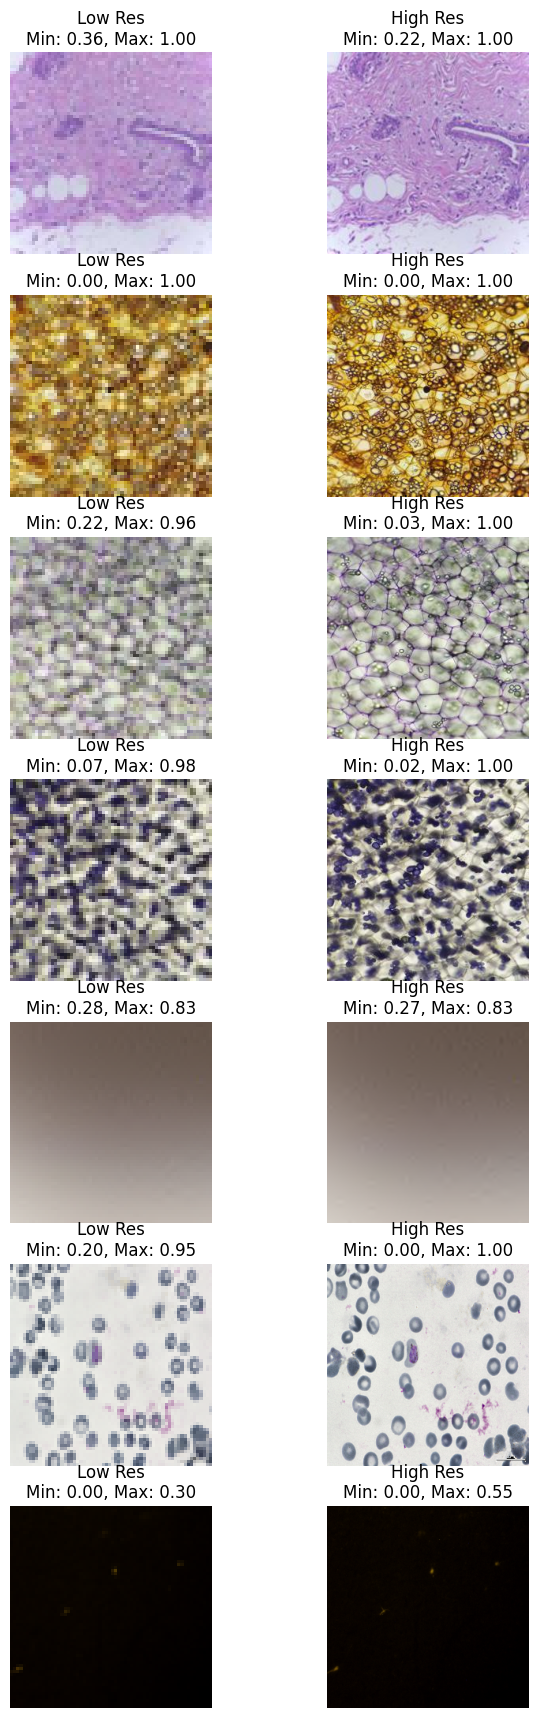

In [ ]:
import logging
import os
import numpy as np
import torch
from PIL import Image
import math
import matplotlib.pyplot as plt

# set logging to remove unnecessary information
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
    if level >= logging.ERROR:
        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
    if level >= logging.WARNING:
        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
    else:
        os.environ["TF_CPP_MIN_LOG_LEVEL"] = "0"
    logging.getLogger("tensorflow").setLevel(level)


set_tf_loglevel(logging.FATAL)  # suppress warnings etc.

paths = {
    "test_x": "/content/super_resolution_256_128/SR_TEST/128x128",
    "test_y": "/content/super_resolution_256_128/SR_TEST/256x256",
    "test_x_wq": "/content/super_resolution_256_128/SR_TEST/128x128_wq",
    "train_x": "/content/super_resolution_256_128/SR_TRAIN/128x128",
    "train_y": "/content/super_resolution_256_128/SR_TRAIN/256x256",
    "train_x_wq": "/content/super_resolution_256_128/SR_TRAIN/128x128_wq",
}

""" paths = {
    'test_x': '/content/super_resolution_256_128_hysto/SR_TEST/128x128',
    'test_y': '/content/super_resolution_256_128_hysto/SR_TEST/256x256',
    'test_x_wq': '/content/super_resolution_256_128_hysto/SR_TEST/128x128_wq',
    'train_x': '/content/super_resolution_256_128_hysto/SR_TRAIN/128x128',
    'train_y': '/content/super_resolution_256_128_hysto/SR_TRAIN/256x256',
    'train_x_wq': '/content/super_resolution_256_128_hysto/SR_TRAIN/128x128_wq',
}
"""

# data generator for object detection
class RestorationDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        paths,
        size_x=(64, 64),
        size_y=(256, 256),
        info=True,
        train=True,
        use_batch=False,
        restorate=False,
        resto_model=None,
        resto_model_tiling=None,
        tiling=False,
        save_path="./resto/",
        use_wq=True,
    ):
        super().__init__()
        if restorate:
            import tensorflow as tf

            print(
                "Restoration may introduce unwanted artifacts, takes longer and may produce unnatural results. Use with caution."
            ) if info else None
        self.use_wq = use_wq
        self.resto_model = (
            None
            if not restorate or resto_model is None
            else tf.keras.models.load_model(resto_model)
        )
        self.resto_model_tiling = (
            None
            if not restorate or resto_model_tiling is None
            else tf.keras.models.load_model(resto_model_tiling)
        )
        self.tiling = tiling
        self.save_path = save_path
        self.restorate = restorate
        self.use_batch = use_batch
        self.info = info
        self.size_x = size_x
        self.size_y = size_y
        self.image_paths_y = (
            self._get_image_paths(paths["train_y"])
            if train
            else self._get_image_paths(paths["test_y"])
        )
        self.image_paths_x = (
            self._get_image_paths(paths["train_x"])
            if train and not use_wq
            else self._get_image_paths(paths["train_x_wq"])
            if train
            else self._get_image_paths(paths["test_x"])
            if not use_wq
            else self._get_image_paths(paths["test_x_wq"])
        )
        self.num_samples = len(self.image_paths_x)
        self.indexes = np.arange(self.num_samples)

    def _get_image_paths(self, directory):
        image_paths = []
        for filename in os.listdir(directory):
            image_paths.append(os.path.join(directory, filename))
        print(f"Found {len(image_paths)} images in {directory}") if self.info else None
        return image_paths

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index, save_images=True):
        image_x = self._load_image(self.image_paths_x[index])
        image_y = self._load_image(self.image_paths_y[index], batch="y")

        image_x = image_x / 255.0
        image_y = image_y / 255.0

        if self.restorate:
            print("resto in:", image_x.shape) if self.info else None
            image_y = self._apply_restoration(
                image_y, self.resto_model, self.resto_model_tiling, self.tiling
            )
            print("returned resto:", image_y.shape) if self.info else None
            if save_images:
                image_y_s = np.transpose(image_y, (1, 2, 0))
                image_y_s = image_y_s * 255.0
                image_y_s = image_y_s.astype(np.uint8)
                image_y_s = Image.fromarray(image_y_s)
                os.makedirs(self.save_path, exist_ok=True)
                image_y_s.save(
                    f"./{self.save_path}/restorated_{self.image_paths_x[index].split('/')[-1]}"
                )
                print(
                    f"saved restorated_{self.image_paths_x[index].split('/')[-1]}"
                ) if self.info else None
            return torch.from_numpy(image_x).float(), torch.from_numpy(image_y).float()

        return torch.from_numpy(image_x).float(), torch.from_numpy(image_y).float()

    def _apply_restoration(
        self, image, model_normal, model_tiling, use_tiling=False
    ):  # non tiling for 1 pred on 256x256, tiling for splitting 256x256 into 4 128x128 and then merging
        # for worst case only as it may produce unnaturally looking images !!!
        # not working with torch.utils.data.DataLoader() as a tf model is used
        image = np.transpose(image, (1, 2, 0))
        image = np.expand_dims(image, axis=0)
        print("restoration in:", image.shape) if self.info else None
        if not use_tiling:
            restorated = model_normal.predict(image)
            restorated = np.squeeze(restorated, axis=0)
            restorated = np.transpose(restorated, (2, 0, 1))
            restorated = (restorated - np.min(restorated)) / (
                np.max(restorated) - np.min(restorated)
            )
            print(
                "restored shape:",
                restorated.shape,
                "restored min/max",
                np.min(restorated),
                np.max(restorated),
            ) if self.info else None
        else:
            # tiling
            print("Tiling restoration") if self.info else None
            patches = []
            for i in range(0, image.shape[1], 128):
                for j in range(0, image.shape[2], 128):
                    patch = image[:, i : i + 128, j : j + 128, :]
                    patches.append(patch)
            patches = np.array(patches)
            print("patches shape:", patches.shape) if self.info else None
            restored_patches = []
            for patch in patches:
                restored_patch = model_tiling.predict(patch)
                restored_patches.append(restored_patch)
            restored_patches = np.array(restored_patches)
            print(
                "restored patches shape:", restored_patches.shape
            ) if self.info else None
            restorated = np.zeros((image.shape[1], image.shape[2], 3))
            for i in range(0, image.shape[1], 128):
                for j in range(0, image.shape[2], 128):
                    patch = restored_patches[0]
                    restorated[i : i + 128, j : j + 128, :] = patch
                    restored_patches = restored_patches[1:]
            restorated = np.transpose(restorated, (2, 0, 1))
            restorated = (restorated - np.min(restorated)) / (
                np.max(restorated) - np.min(restorated)
            )
        return restorated

    def _load_image(self, path, batch="x"):
        image = Image.open(path).convert("RGB")
        image = image.resize(
            self.size_x if batch == "x" else self.size_y, resample=Image.BICUBIC
        )
        image = np.array(image)
        print(image.shape) if self.info else None
        if self.use_batch:
            image = np.transpose(image, (0, 3, 1, 2))
        image = np.transpose(image, (2, 0, 1))
        print("_load_image out:", image.shape) if self.info else None
        return image

# normal generator without further restoration
train_data = RestorationDataset(
    paths,
    train=True,
    info=False,
    restorate=False,
    resto_model="/content/super_resolution/super resolution/hat_pt/NafNet_5M4F_256",
    tiling=True,
    resto_model_tiling="/content/super_resolution/super resolution/hat_pt/NafNet_8M_128",
    use_wq=False,
)
test_data = RestorationDataset(
    paths,
    train=False,
    info=False,
    restorate=False,
    resto_model="/content/super_resolution/super resolution/hat_pt/NafNet_5M4F_256",
    use_wq=False,
)

BATCH_SIZE = 12

gen_params_train = {
    "batch_size": BATCH_SIZE,
    "shuffle": True,
    "num_workers": 0,
}
gen_params_test = {
    "batch_size": BATCH_SIZE,
    "shuffle": False,
    "num_workers": 0,
}

train_generator = torch.utils.data.DataLoader(
    train_data, **gen_params_train
)  # to batchable python generator
test_generator = torch.utils.data.DataLoader(test_data, **gen_params_test)


# display test images and further information
def display_images(generator, amount=7, info=True):
    fig, axes = plt.subplots(nrows=amount, ncols=2, figsize=(7.5, 21.5))
    for i in range(amount):
        x, y = generator[i]
        x, y = np.transpose(x, (1, 2, 0)), np.transpose(y, (1, 2, 0))
        if x.shape[-1] == 1:
            x = np.repeat(x, 3, axis=-1)
        if y.shape[-1] == 1:
            y = np.repeat(y, 3, axis=-1)
        axes[i, 0].imshow(x)
        axes[i, 0].axis("off")
        if info:
            axes[i, 0].set_title(f"Low Res\nMin: {x.min():.2f}, Max: {x.max():.2f}")
        axes[i, 1].imshow(y)
        axes[i, 1].axis("off")
        if info:
            axes[i, 1].set_title(f"High Res\nMin: {y.min():.2f}, Max: {y.max():.2f}")
    plt.show()


display_images(train_data)

In [ ]:
import torch
from torch.optim.optimizer import Optimizer
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp
from torchgeometry.image import get_gaussian_kernel2d
import torch.nn.functional as F

# model optimizer
class Lion(Optimizer):
    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas: tuple = (0.9, 0.99),
        weight_decay: float = 0.0,
    ):
        assert lr > 0.0
        assert all([0.0 <= beta <= 1.0 for beta in betas])
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in filter(lambda p: p.grad is not None, group["params"]):
                # parameter
                grad, lr, wd, beta1, beta2, state = (
                    p.grad,
                    group["lr"],
                    group["weight_decay"],
                    *group["betas"],
                    self.state[p],
                )
                if len(state) == 0:
                    state["exp_avg"] = torch.zeros_like(p)
                exp_avg = state["exp_avg"]

                # Lion optimizer
                p.data.mul_(1 - lr * wd)
                update = exp_avg.clone().lerp_(grad, 1 - beta1)
                p.add_(torch.sign(update), alpha=-lr)
                exp_avg.lerp_(grad, 1 - beta2)
        return loss


#! https://github.com/styler00dollar/pytorch-loss-functions; @styler00dollar


def _binarize(y_data, threshold):
    """
    args:
        y_data : [float] 4-d tensor in [batch_size, channels, img_rows, img_cols]
        threshold : [float] [0.0, 1.0]
    return 4-d binarized y_data
    """
    y_data[y_data < threshold] = 0.0
    y_data[y_data >= threshold] = 1.0
    return y_data

# metrics for super resolution
class PSNRMetric(object):
    def __init__(self, des="Peak Signal to Noise Ratio"):
        self.des = des
        self.metric_value = 0

    def __repr__(self):
        return "PSNR"

    def __call__(self, y_pred, y_true, dim=1, threshold=None):
        if threshold:
            y_pred = _binarize(y_pred, threshold)
        mse = torch.mean((y_pred - y_true) ** 2)
        self.metric_value = 10 * torch.log10(1 / mse)
        return self.metric_value

    def value(self):
        return self.metric_value


class SSIMMetric(object):
    def __init__(self, des="structural similarity index"):
        self.des = des
        self.metric_value = 0

    def __repr__(self):
        return "SSIM"

    def gaussian(self, w_size, sigma):
        gauss = torch.Tensor(
            [
                math.exp(-((x - w_size // 2) ** 2) / float(2 * sigma**2))
                for x in range(w_size)
            ]
        )
        return gauss / gauss.sum()

    def create_window(self, w_size, channel=1):
        _1D_window = self.gaussian(w_size, 1.5).unsqueeze(1)
        _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
        window = _2D_window.expand(channel, 1, w_size, w_size).contiguous()
        return window

    def __call__(self, y_pred, y_true, w_size=11, size_average=True, full=False):
        if torch.max(y_pred) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(y_pred) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val

        padd = 0
        (_, channel, height, width) = y_pred.size()
        window = self.create_window(w_size, channel=channel).to(y_pred.device)

        mu1 = F.conv2d(y_pred, window, padding=padd, groups=channel)
        mu2 = F.conv2d(y_true, window, padding=padd, groups=channel)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        sigma1_sq = (
            F.conv2d(y_pred * y_pred, window, padding=padd, groups=channel) - mu1_sq
        )
        sigma2_sq = (
            F.conv2d(y_true * y_true, window, padding=padd, groups=channel) - mu2_sq
        )
        sigma12 = (
            F.conv2d(y_pred * y_true, window, padding=padd, groups=channel) - mu1_mu2
        )

        C1 = (0.01 * L) ** 2
        C2 = (0.03 * L) ** 2

        v1 = 2.0 * sigma12 + C2
        v2 = sigma1_sq + sigma2_sq + C2
        cs = torch.mean(v1 / v2)

        ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

        if size_average:
            ret = ssim_map.mean()
        else:
            ret = ssim_map.mean(1).mean(1).mean(1)

        self.metric_value = ret
        if full:
            return ret, cs
        return ret

    def value(self):
        return self.metric_value


class SSIM(nn.Module):
    r"""Creates a criterion that measures the Structural Similarity (SSIM)
    index between each element in the input `x` and target `y`.

    The index can be described as:

    .. math::

      \text{SSIM}(x, y) = \frac{(2\mu_x\mu_y+c_1)(2\sigma_{xy}+c_2)}
      {(\mu_x^2+\mu_y^2+c_1)(\sigma_x^2+\sigma_y^2+c_2)}

    where:
      - :math:`c_1=(k_1 L)^2` and :math:`c_2=(k_2 L)^2` are two variables to
        stabilize the division with weak denominator.
      - :math:`L` is the dynamic range of the pixel-values (typically this is
        :math:`2^{\#\text{bits per pixel}}-1`).

    the loss, or the Structural dissimilarity (DSSIM) can be finally described
    as:

    .. math::

      \text{loss}(x, y) = \frac{1 - \text{SSIM}(x, y)}{2}

    Arguments:
        window_size (int): the size of the kernel.
        max_val (float): the dynamic range of the images. Default: 1.
        reduction (str, optional): Specifies the reduction to apply to the
         output: 'none' | 'mean' | 'sum'. 'none': no reduction will be applied,
         'mean': the sum of the output will be divided by the number of elements
         in the output, 'sum': the output will be summed. Default: 'none'.

    Returns:
        Tensor: the ssim index.

    Shape:
        - Input: :math:`(B, C, H, W)`
        - Target :math:`(B, C, H, W)`
        - Output: scale, if reduction is 'none', then :math:`(B, C, H, W)`

    Examples::

        >>> input1 = torch.rand(1, 4, 5, 5)
        >>> input2 = torch.rand(1, 4, 5, 5)
        >>> ssim = tgm.losses.SSIM(5, reduction='none')
        >>> loss = ssim(input1, input2)  # 1x4x5x5
    """

    def __init__(
        self, window_size: int, reduction: str = "none", max_val: float = 1.0
    ) -> None:
        super(SSIM, self).__init__()
        self.window_size: int = window_size
        self.max_val: float = max_val
        self.reduction: str = reduction

        self.window: torch.Tensor = get_gaussian_kernel2d(
            (window_size, window_size), (1.5, 1.5)
        )
        self.padding: int = self.compute_zero_padding(window_size)

        self.C1: float = (0.01 * self.max_val) ** 2
        self.C2: float = (0.03 * self.max_val) ** 2

    @staticmethod
    def compute_zero_padding(kernel_size: int) -> int:
        """Computes zero padding."""
        return (kernel_size - 1) // 2

    def filter2D(
        self, input: torch.Tensor, kernel: torch.Tensor, channel: int
    ) -> torch.Tensor:
        return F.conv2d(input, kernel, padding=self.padding, groups=channel)

    def forward(self, img1: torch.Tensor, img2: torch.Tensor) -> torch.Tensor:
        if not torch.is_tensor(img1):
            raise TypeError(
                "Input img1 type is not a torch.Tensor. Got {}".format(type(img1))
            )
        if not torch.is_tensor(img2):
            raise TypeError(
                "Input img2 type is not a torch.Tensor. Got {}".format(type(img2))
            )
        if not len(img1.shape) == 4:
            raise ValueError(
                "Invalid img1 shape, we expect BxCxHxW. Got: {}".format(img1.shape)
            )
        if not len(img2.shape) == 4:
            raise ValueError(
                "Invalid img2 shape, we expect BxCxHxW. Got: {}".format(img2.shape)
            )
        if not img1.shape == img2.shape:
            raise ValueError(
                "img1 and img2 shapes must be the same. Got: {}".format(
                    img1.shape, img2.shape
                )
            )
        if not img1.device == img2.device:
            raise ValueError(
                "img1 and img2 must be in the same device. Got: {}".format(
                    img1.device, img2.device
                )
            )
        if not img1.dtype == img2.dtype:
            raise ValueError(
                "img1 and img2 must be in the same dtype. Got: {}".format(
                    img1.dtype, img2.dtype
                )
            )
        # prepare kernel
        b, c, h, w = img1.shape
        tmp_kernel: torch.Tensor = self.window.to(img1.device).to(img1.dtype)
        kernel: torch.Tensor = tmp_kernel.repeat(c, 1, 1, 1)

        # compute local mean per channel
        mu1: torch.Tensor = self.filter2D(img1, kernel, c)
        mu2: torch.Tensor = self.filter2D(img2, kernel, c)

        mu1_sq = mu1.pow(2)
        mu2_sq = mu2.pow(2)
        mu1_mu2 = mu1 * mu2

        # compute local sigma per channel
        sigma1_sq = self.filter2D(img1 * img1, kernel, c) - mu1_sq
        sigma2_sq = self.filter2D(img2 * img2, kernel, c) - mu2_sq
        sigma12 = self.filter2D(img1 * img2, kernel, c) - mu1_mu2

        ssim_map = ((2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)) / (
            (mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2)
        )

        loss = torch.clamp(1.0 - ssim_map, min=0, max=1) / 2.0

        if self.reduction == "mean":
            loss = torch.mean(loss)
        elif self.reduction == "sum":
            loss = torch.sum(loss)
        elif self.reduction == "none":
            pass
        return loss

# loss functions
def ssim_loss(
    img1: torch.Tensor,
    img2: torch.Tensor,
    window_size: int = 11,
    reduction: str = "mean",
    max_val: float = 1.0,
) -> torch.Tensor:
    r"""Function that measures the Structural Similarity (SSIM) index between
    each element in the input `x` and target `y`.

    See :class:`torchgeometry.losses.SSIM` for details.
    """
    return SSIM(window_size, reduction, max_val)(img1, img2).mean()


def smooth_l1(
    input,
    target,
    size_average=None,
    reduce=None,
    reduction: str = "mean",
    beta: float = 1.0,
):
    return F.smooth_l1_loss(input, target, size_average, reduce, reduction, beta)


# combined loss to get best outcomes for super resolution
# benefits of l1 and ssim combined
class CombinedLoss(torch.nn.Module):
    def __init__(self, counter_weight: float = 0.5):
        super(CombinedLoss, self).__init__()
        self.counter_weight = counter_weight # weigh one loss more than the other

    def forward(self, preds, target):
        ssim_loss_value = ssim_loss(preds, target)
        l1_loss_value = smooth_l1(preds, target)

        combined_loss = ssim_loss_value * self.counter_weight + l1_loss_value * (
            1 - self.counter_weight
        )
        return combined_loss

In [ ]:
import time
import datetime
import csv

# save training progress to csv
def write_to_csv(
    loss,
    metrics,
    epoch,
    header_written=False,
    filename: str = f"train_{datetime.date.today()}.csv",
):
    with open(filename, "a") as f:
        writer = csv.writer(f)
        if not header_written:
            writer.writerow(["epoch", "loss", "PSNR", "SSIM"])
            header_written = True
        writer.writerow([epoch + 1, loss, metrics["PSNR"], metrics["SSIM"]])
    return header_written

# train step function
def train_step(
    model,
    train_generator,
    metrics,
    loss_fn,
    optimizer,
    device,
    save_path="model_epoch_",
    epochs: int = 10,
    save: bool = False,
    test_after_epoch: bool = False,
    test_generator= None,
    load_saved_model: bool = False,
    saved_model_path: str = None,
):
    if load_saved_model:
        model.load_state_dict(torch.load(saved_model_path))
    model.train()
    total_loss = 0 # for loss calculation
    total_samples = 0 # for loss calculation
    start = time.time() # time measurement
    num_batches = len(train_generator)
    loss_checker = [] # "lr scheduler"
    loss_down = 0 # if loss increases 6 times in a row, training is stopped

    for epoch in range(epochs):
        batch = 0
        total_loss_epoch = 0
        total_samples_epoch = 0
        average_metrics = []
        print(f"Epoch {epoch+1}/{epochs}\n-------------------------------")
        for x, y in train_generator:
            x = x.to(device)
            y = y.to(device)
            batch += 1
            if len(loss_checker) > 1:
                if loss_down < 6:
                    if loss_checker[-1] > loss_checker[-2]:
                        print(
                            f"Loss increased from {loss_checker[-2]} to {loss_checker[-1]}\n",
                            end="\n",
                            flush=True,
                        )
                        optimizer.param_groups[0]["lr"] *= 0.1
                        loss_down += 1
                else:
                    raise Exception("Loss increased too many times")
            optimizer.zero_grad()

            outputs = model(x)
            loss = loss_fn(outputs, y)
            batch_size = x.size(0)

            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_samples += batch_size
            total_loss_epoch += loss.item() * batch_size
            total_samples_epoch += batch_size

            for metric in metrics.values():
                metric(outputs, y)

            avg_loss = total_loss / total_samples
            avg_loss_epoch = total_loss_epoch / total_samples_epoch
            metric_values = {
                metric_name: metric.value().item()
                for metric_name, metric in metrics.items()
            }
            metric_values = {
                metric_name: round(metric_value, 4)
                for metric_name, metric_value in metric_values.items()
            }
            average_metrics.append(metric_values)

            current_time = time.time()
            elapsed_time = current_time - start
            avg_time_per_batch = elapsed_time / batch
            remainig_batches = num_batches - batch
            remaining_time = remainig_batches * avg_time_per_batch
            print(
                f"\r Batch [{batch}/{num_batches}] Loss: {avg_loss:.4f} Metrics: {metric_values} Elapsed Time: {elapsed_time:.2f}s/{elapsed_time/60:.2f}m Remaining Time (epoch): {remaining_time:.2f}s/{remaining_time/60:.2f}m",
                flush=True,
                end=" ",
            )
            header_written = write_to_csv(
                avg_loss, metric_values, epoch, header_written if batch > 1 else False
            )

        avg_loss = total_loss / total_samples
        avg_loss_epoch = total_loss_epoch / total_samples_epoch
        print(avg_loss)
        avg_metrics = {
            metric_name: sum([metric[metric_name] for metric in average_metrics])
            / len(average_metrics)
            for metric_name in average_metrics[0].keys()
        }
        avg_metrics = {
            metric_name: round(metric_value, 4)
            for metric_name, metric_value in avg_metrics.items()
        }
        loss_checker.append(avg_loss)
        print(
            f"Epoch {epoch + 1} finished. \n Avg Loss: {avg_loss_epoch:.4f} Avg Metrics: {avg_metrics}"
        )
        if save:
            torch.save(model.state_dict(), f"{save_path}{epoch + 1}.pth")
            print(f"Model state dict saved at {save_path}{epoch + 1}.pth")
            torch.save(model, f"{save_path}{epoch + 1}_cm.pth")
            print(f"Complete model saved at {save_path}{epoch + 1}_cm.pth")

        # test the model after each epoch
        if test_after_epoch:
            test_step(model, test_generator, metrics, loss_fn, device)

# test step function
def test_step(
    model,
    test_generator,
    metrics,
    loss_fn,
    device,
    load_saved_model: bool = False,
    saved_model_path: str = None,
):
    if load_saved_model:
        model.load_state_dict(torch.load(saved_model_path))
    model.eval()
    total_loss = 0
    total_samples = 0
    avg_metrics = []

    with torch.no_grad():
        for x, y in test_generator:
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            loss = loss_fn(outputs, y)
            batch_size = x.size(0)

            total_loss += loss.item() * batch_size
            total_samples += batch_size

            for metric in metrics.values():
                metric(outputs, y)

            metric_values = {
                metric_name: metric.value().item()
                for metric_name, metric in metrics.items()
            }
            metric_values = {
                metric_name: round(metric_value, 4)
                for metric_name, metric_value in metric_values.items()
            }
            avg_metrics.append(metric_values)

    avg_metrics = {
        metric_name: sum([metric[metric_name] for metric in avg_metrics])
        / len(avg_metrics)
        for metric_name in avg_metrics[0].keys()
    }
    avg_metrics = {
        metric_name: round(metric_value, 4)
        for metric_name, metric_value in avg_metrics.items()
    }
    avg_loss = total_loss / total_samples
    print(f"Test - Avg Loss (Batch): {avg_loss:.4f} Avg Metrics: {avg_metrics}")
    write_to_csv(
        avg_loss,
        metric_values,
        0,
        header_written=False,
        filename=f"test_{datetime.date.today()}.csv",
    )


optimizer = Lion(model.parameters(), lr=1e-5, weight_decay=1e-6)
# loss_fn = torch.nn.MSELoss()
loss_fn = CombinedLoss(counter_weight=0.6)
num_epochs = 3
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

metrics = {"PSNR": PSNRMetric(), "SSIM": SSIMMetric()}

train_step(
    model,
    train_generator,
    metrics,
    loss_fn,
    optimizer,
    device,
    save=True,
    save_path="model_epoch_",
    epochs=num_epochs,
    test_after_epoch=True,
    test_generator=test_generator,
    saved_model_path="/content/drive/MyDrive/model_epoch_1.pth", # load saved model
    load_saved_model=False, # load saved model
)
# test_step(model, test_data, metrics, loss_fn, device)

In [ ]:
# move model to drive
import shutil

shutil.copy("model_epoch_2.pth", "/content/drive/MyDrive/")

'/content/drive/MyDrive/model_epoch_2.pth'